In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, auc
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize

In [3]:
def load_from_h5(filename, target_size=(224, 224)):
    with h5py.File(filename, "r") as h5f:
        X = np.array(h5f["X"])
        y = np.array(h5f["y"])
    print(f"✅ Loaded {filename} successfully. Resizing to {target_size}...")

    # Resize each image to 224x224
    X_resized = np.array([cv2.resize(img, target_size) for img in X])

    return X_resized, y

X, y = load_from_h5("/content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/dataset/dataset.h5")

✅ Loaded /content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/dataset/dataset.h5 successfully. Resizing to (224, 224)...


In [4]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3200, 224, 224, 3)
y shape: (3200,)


In [5]:
X = X / 255.0

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [7]:
class_names = sorted([
    'apple_black_rot', 'apple_healthy', 'apple_scab',
    'corn_common_rust', 'corn_healthy', 'corn_northern_blight',
    'grape_black_rot', 'grape_esca', 'grape_healthy',
    'pepper_bacterial_spot', 'pepper_healthy',
    'strawberry_healthy', 'strawberry_leaf_scorch',
    'tomato_bacterial_spot', 'tomato_healthy', 'tomato_septoria_leaf_spot'
])

fig = plt.figure(figsize=(20, 20))
fig.suptitle('Sample Images For Each Classes')
displayed_images = {}

for i in range(len(X_train)):
    if y_train[i] not in displayed_images:
        plt.subplot(5, 5, len(displayed_images) + 1)
        plt.grid(False)
        plt.imshow(X_train[i])
        plt.xlabel(class_names[y_train[i]])
        displayed_images[y_train[i]] = True

    if len(displayed_images) == len(class_names):
        break
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# === Convert to PyTorch tensors ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# === DataLoaders ===
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# === Output shapes for verification ===
num_classes = len(class_names)

In [10]:
print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)
print()
print("X_test Shape: ",X_test.shape)
print("y_test Shape: ",y_test.shape)
print()
print("X_valid Shape: ",X_valid.shape)
print("y_valid Shape: ",y_valid.shape)

X_train Shape:  torch.Size([1920, 3, 224, 224])
y_train Shape:  torch.Size([1920])

X_test Shape:  torch.Size([640, 3, 224, 224])
y_test Shape:  torch.Size([640])

X_valid Shape:  torch.Size([640, 3, 224, 224])
y_valid Shape:  torch.Size([640])


In [11]:
# 🔹 Define CNN Model
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Freeze all layers first
        for name, param in self.model.named_parameters():
          if "layer4" in name or "fc" in name:  # Unfreeze last ResNet block + classifier
              param.requires_grad = True
          else:
              param.requires_grad = False


        # Replace the final FC layer for classification
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

resnet_model = ResNet50(num_classes).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.0003)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [13]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [14]:
num_epochs = 50
best_train_accuracy = 0
best_valid_accuracy = 0
best_test_accuracy = 0
best_epoch = 0

save_path = "/content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/cnn_plant_disease_detection/models"
os.makedirs(save_path, exist_ok=True)

# 🔹 Training Loop
for epoch_idx in range(num_epochs):
    resnet_model.train()
    train_running_loss, train_running_accuracy = 0.0, 0.0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pred = resnet_model(images)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
        _, pred_labels = torch.max(pred.detach(), 1)
        train_running_accuracy += (pred_labels == labels).sum().item() / labels.size(0)

    avg_train_loss = train_running_loss / len(train_loader)
    avg_train_accuracy = train_running_accuracy / len(train_loader)

    print(f"Epoch {epoch_idx+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_accuracy:.2f}%")
    best_train_accuracy = max(best_train_accuracy, avg_train_accuracy)

    # 🔹 Validation Loop
    resnet_model.eval()
    valid_running_loss, valid_running_accuracy = 0.0, 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images, labels = images.to(device), labels.to(device)
            pred = resnet_model(images)
            loss = loss_fn(pred, labels)
            valid_running_loss += loss.item()
            _, pred_labels = torch.max(pred.detach(), 1)
            valid_running_accuracy += (pred_labels == labels).sum().item() / labels.size(0)

    scheduler.step()

    avg_valid_loss = valid_running_loss / len(valid_loader)
    avg_valid_accuracy = valid_running_accuracy / len(valid_loader)

    print(f"Epoch {epoch_idx+1}/{num_epochs} - Valid Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_accuracy:.2f}%")
    best_valid_accuracy = max(best_valid_accuracy, avg_valid_accuracy)

    # 🔹 Save Best Model
    if best_test_accuracy < avg_valid_accuracy:
        best_test_accuracy = avg_valid_accuracy
        best_epoch = epoch_idx + 1
        torch.save(resnet_model.state_dict(), os.path.join(save_path, f"RESNET_{epoch_idx+1}.pth"))
        print(f"🔥 Model saved at: {os.path.join(save_path, f'RESNET_{epoch_idx+1}.pth')} with accuracy: {best_test_accuracy:.2f}%")

# 🔹 Final Test Evaluation
resnet_model.eval()
test_running_accuracy = 0.0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        pred = resnet_model(images)
        _, pred_labels = torch.max(pred, 1)
        test_running_accuracy += (pred_labels == labels).sum().item() / labels.size(0)

best_test_accuracy = test_running_accuracy / len(test_loader)

100%|██████████| 30/30 [00:04<00:00,  7.35it/s]


Epoch 1/50 - Train Loss: 0.8702, Accuracy: 0.78%


100%|██████████| 10/10 [00:00<00:00, 10.28it/s]


Epoch 1/50 - Valid Loss: 0.2031, Accuracy: 0.93%
🔥 Model saved at: /content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/cnn_plant_disease_detection/models/RESNET_1.pth with accuracy: 0.93%


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Epoch 2/50 - Train Loss: 0.0648, Accuracy: 0.98%


100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


Epoch 2/50 - Valid Loss: 0.0256, Accuracy: 0.99%
🔥 Model saved at: /content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/cnn_plant_disease_detection/models/RESNET_2.pth with accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.98it/s]


Epoch 3/50 - Train Loss: 0.0415, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.30it/s]


Epoch 3/50 - Valid Loss: 0.0835, Accuracy: 0.97%


100%|██████████| 30/30 [00:03<00:00,  7.94it/s]


Epoch 4/50 - Train Loss: 0.0182, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


Epoch 4/50 - Valid Loss: 0.0476, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.93it/s]


Epoch 5/50 - Train Loss: 0.0313, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.27it/s]


Epoch 5/50 - Valid Loss: 0.0709, Accuracy: 0.98%


100%|██████████| 30/30 [00:03<00:00,  7.95it/s]


Epoch 6/50 - Train Loss: 0.0566, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.26it/s]


Epoch 6/50 - Valid Loss: 0.0829, Accuracy: 0.98%


100%|██████████| 30/30 [00:03<00:00,  7.97it/s]


Epoch 7/50 - Train Loss: 0.0426, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 7/50 - Valid Loss: 0.1088, Accuracy: 0.97%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 8/50 - Train Loss: 0.0271, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.29it/s]


Epoch 8/50 - Valid Loss: 0.0265, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 9/50 - Train Loss: 0.0127, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 9/50 - Valid Loss: 0.0496, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 10/50 - Train Loss: 0.0124, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 10/50 - Valid Loss: 0.0294, Accuracy: 0.99%
🔥 Model saved at: /content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/cnn_plant_disease_detection/models/RESNET_10.pth with accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.02it/s]


Epoch 11/50 - Train Loss: 0.0037, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 11/50 - Valid Loss: 0.0527, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 12/50 - Train Loss: 0.0027, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


Epoch 12/50 - Valid Loss: 0.0205, Accuracy: 1.00%
🔥 Model saved at: /content/drive/MyDrive/Marcus Colab/marcus_plant_disease_detection/cnn_plant_disease_detection/models/RESNET_12.pth with accuracy: 1.00%


100%|██████████| 30/30 [00:03<00:00,  8.02it/s]


Epoch 13/50 - Train Loss: 0.0032, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 13/50 - Valid Loss: 0.0205, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 14/50 - Train Loss: 0.0010, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 14/50 - Valid Loss: 0.0246, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 15/50 - Train Loss: 0.0050, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


Epoch 15/50 - Valid Loss: 0.0239, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 16/50 - Train Loss: 0.0008, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 16/50 - Valid Loss: 0.0254, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 17/50 - Train Loss: 0.0009, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 17/50 - Valid Loss: 0.0634, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 18/50 - Train Loss: 0.0075, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 18/50 - Valid Loss: 0.0352, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 19/50 - Train Loss: 0.0032, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 19/50 - Valid Loss: 0.0242, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 20/50 - Train Loss: 0.0029, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 20/50 - Valid Loss: 0.0160, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 21/50 - Train Loss: 0.0019, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]


Epoch 21/50 - Valid Loss: 0.0213, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.98it/s]


Epoch 22/50 - Train Loss: 0.0007, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]


Epoch 22/50 - Valid Loss: 0.0233, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.97it/s]


Epoch 23/50 - Train Loss: 0.0007, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 23/50 - Valid Loss: 0.0168, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.98it/s]


Epoch 24/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 24/50 - Valid Loss: 0.0180, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.96it/s]


Epoch 25/50 - Train Loss: 0.0008, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]


Epoch 25/50 - Valid Loss: 0.0177, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 26/50 - Train Loss: 0.0006, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.29it/s]


Epoch 26/50 - Valid Loss: 0.0210, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 27/50 - Train Loss: 0.0010, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.30it/s]


Epoch 27/50 - Valid Loss: 0.0257, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 28/50 - Train Loss: 0.0005, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 28/50 - Valid Loss: 0.0240, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 29/50 - Train Loss: 0.0007, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 29/50 - Valid Loss: 0.0207, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 30/50 - Train Loss: 0.0007, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 30/50 - Valid Loss: 0.0148, Accuracy: 1.00%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 31/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


Epoch 31/50 - Valid Loss: 0.0129, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 32/50 - Train Loss: 0.0007, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 32/50 - Valid Loss: 0.0136, Accuracy: 1.00%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 33/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 33/50 - Valid Loss: 0.0138, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 34/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.30it/s]


Epoch 34/50 - Valid Loss: 0.0117, Accuracy: 1.00%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 35/50 - Train Loss: 0.0013, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


Epoch 35/50 - Valid Loss: 0.0245, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 36/50 - Train Loss: 0.0004, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


Epoch 36/50 - Valid Loss: 0.0274, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 37/50 - Train Loss: 0.0004, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]


Epoch 37/50 - Valid Loss: 0.0284, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 38/50 - Train Loss: 0.0004, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 38/50 - Valid Loss: 0.0257, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 39/50 - Train Loss: 0.0002, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 39/50 - Valid Loss: 0.0281, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 40/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.34it/s]


Epoch 40/50 - Valid Loss: 0.0260, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 41/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


Epoch 41/50 - Valid Loss: 0.0260, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 42/50 - Train Loss: 0.0002, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]


Epoch 42/50 - Valid Loss: 0.0269, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 43/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


Epoch 43/50 - Valid Loss: 0.0275, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 44/50 - Train Loss: 0.0002, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]


Epoch 44/50 - Valid Loss: 0.0253, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 45/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 45/50 - Valid Loss: 0.0244, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  8.00it/s]


Epoch 46/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 46/50 - Valid Loss: 0.0274, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 47/50 - Train Loss: 0.0002, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.32it/s]


Epoch 47/50 - Valid Loss: 0.0267, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 48/50 - Train Loss: 0.0003, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Epoch 48/50 - Valid Loss: 0.0252, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 49/50 - Train Loss: 0.0002, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.30it/s]


Epoch 49/50 - Valid Loss: 0.0229, Accuracy: 0.99%


100%|██████████| 30/30 [00:03<00:00,  7.99it/s]


Epoch 50/50 - Train Loss: 0.0002, Accuracy: 1.00%


100%|██████████| 10/10 [00:00<00:00, 10.33it/s]


Epoch 50/50 - Valid Loss: 0.0248, Accuracy: 0.99%


100%|██████████| 10/10 [00:00<00:00, 10.37it/s]


In [15]:
print("Final Best Accuracies")
print(f"Best Train Accuracy: {best_train_accuracy * 100:.2f}%")
print(f"Best Validation Accuracy: {best_valid_accuracy * 100:.2f}%")
print(f"Best Test Accuracy: {best_test_accuracy * 100:.2f}% \n(at epoch {best_epoch})")

Final Best Accuracies
Best Train Accuracy: 100.00%
Best Validation Accuracy: 99.53%
Best Test Accuracy: 99.38% 
(at epoch 12)


In [16]:
# Evaluate on Test Set
resnet_model.eval()
with torch.no_grad():
    X_test = X_test.contiguous()
    y_pred_test_proba = resnet_model(X_test)
    y_pred_test = torch.argmax(y_pred_test_proba, axis=1).cpu().numpy()
    y_test_np = y_test.cpu().numpy()


In [17]:
print("Classification Report:")
print(classification_report(y_test_np, y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40
           6       0.98      1.00      0.99        40
           7       1.00      0.97      0.99        40
           8       1.00      1.00      1.00        40
           9       1.00      0.95      0.97        40
          10       0.95      1.00      0.98        40
          11       1.00      1.00      1.00        40
          12       1.00      1.00      1.00        40
          13       0.98      1.00      0.99        40
          14       1.00      1.00      1.00        40
          15       1.00      0.97      0.99        40

    accuracy                           0.99       640
   

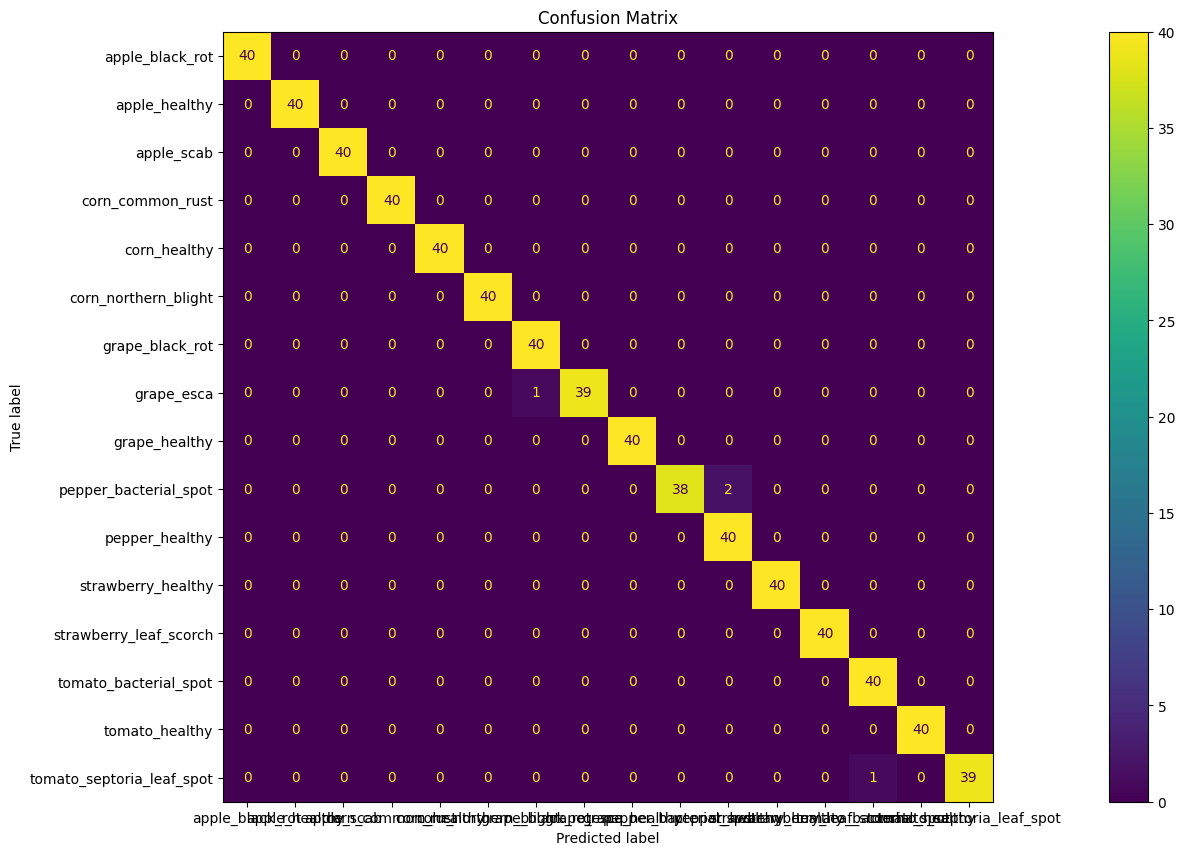

In [18]:
cm = confusion_matrix(y_test_np, y_pred_test, labels=np.unique(y_test_np))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title("Confusion Matrix")
disp.plot(ax=ax)
plt.show()

In [19]:
class_labels = np.arange(num_classes)
y_test_encoded = label_binarize(y_test_np, classes=class_labels)

y_pred_test_proba = y_pred_test_proba.cpu().numpy()

roc_auc = roc_auc_score(y_test_encoded, y_pred_test_proba, multi_class="ovo")
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.999953125


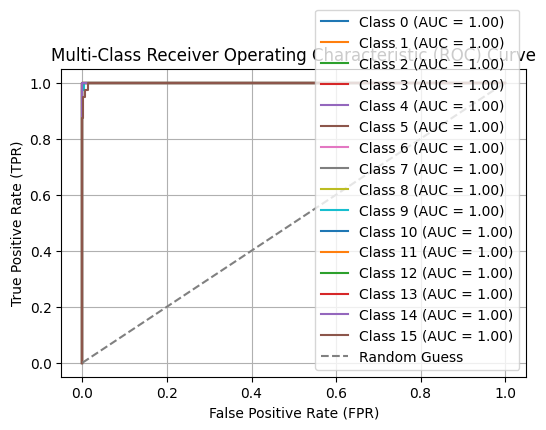

In [20]:
# Compute ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_pred_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot random baseline (chance level)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

# Format the plot
plt.title("Multi-Class Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [21]:
# Evaluate on Validation Set
resnet_model.eval()
with torch.no_grad():
    X_valid = X_valid.contiguous()
    y_pred_valid_proba = resnet_model(X_valid)
    y_pred_valid = torch.argmax(y_pred_valid_proba, axis=1).cpu().numpy()
    y_valid_np = y_valid.cpu().numpy()


In [22]:
print("Classification Report:")
print(classification_report(y_valid_np, y_pred_valid))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.97      0.99        40
           2       0.98      1.00      0.99        40
           3       1.00      1.00      1.00        40
           4       1.00      1.00      1.00        40
           5       1.00      1.00      1.00        40
           6       1.00      0.97      0.99        40
           7       0.98      1.00      0.99        40
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        40
          10       1.00      1.00      1.00        40
          11       1.00      1.00      1.00        40
          12       1.00      1.00      1.00        40
          13       0.95      1.00      0.98        40
          14       1.00      1.00      1.00        40
          15       1.00      0.95      0.97        40

    accuracy                           0.99       640
   

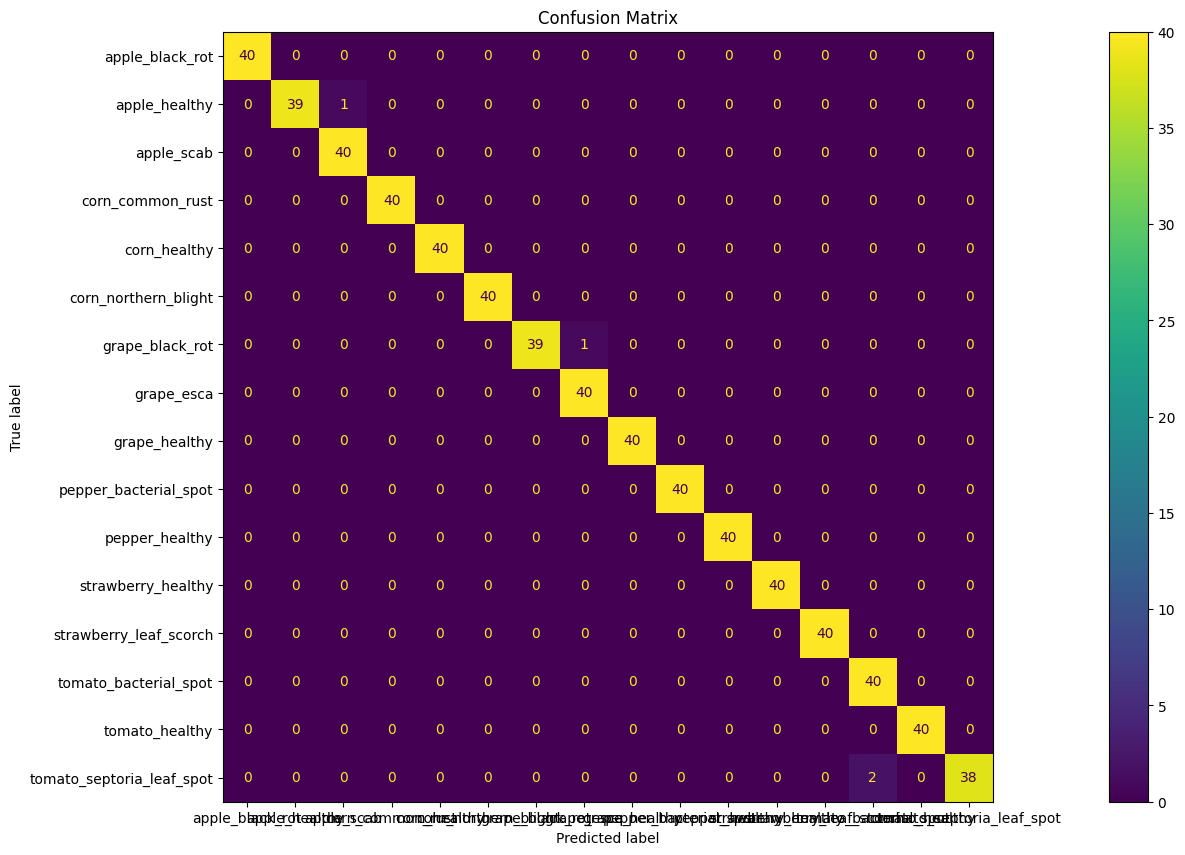

In [23]:
cm = confusion_matrix(y_valid_np, y_pred_valid, labels=np.unique(y_valid_np))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_title("Confusion Matrix")
disp.plot(ax=ax)
plt.show()

In [24]:
class_labels = np.arange(num_classes)
y_valid_encoded = label_binarize(y_valid_np, classes=class_labels)

y_pred_valid_proba = y_pred_valid_proba.cpu().numpy()

roc_auc = roc_auc_score(y_valid_encoded, y_pred_valid_proba, multi_class="ovo")
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9997968749999999


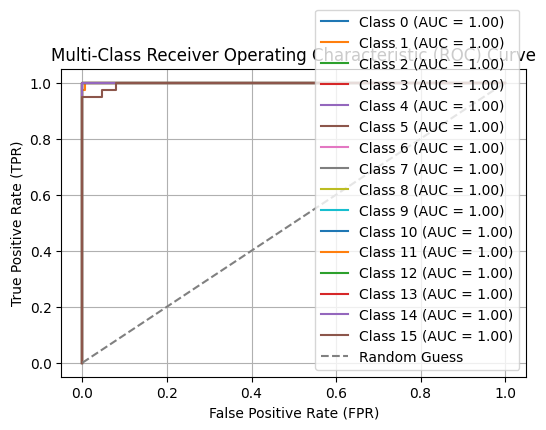

In [25]:
# Compute ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_valid_encoded[:, i], y_pred_valid_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot random baseline (chance level)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

# Format the plot
plt.title("Multi-Class Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()